### document classification example
based on sklearn site example entitled "Classification of text documents using sparse features"
https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html

 - some of the code appears to be out of date (e.g. old string formatting syntax)
 - much of it is also geared toward CLI runs - adapting it as a notebook
 
 The BSD 3-clause license allows you almost unlimited freedom with the software so long as you include the BSD copyright and license notice in it.

© 2007 - 2021, scikit-learn developers (BSD License). 

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
1.     Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.
1.     Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission. 

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [1]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Lars Buitinck
# License: BSD 3 clause
# modified: Robert Sunderland - 2021

import numpy as np
import sys
from time import time
import matplotlib.pyplot as plt
import pandas as pd

#changed from CLI options to inline

optdict = {'print_report': True,# Print a detailed classification report.
 'select_chi2': 1500,#Select some number of features using a chi-squared test
 'print_cm': True,#Print the confusion matrix.
 'print_top10': True, #Print ten most discriminative terms per class for every classifier
 'all_categories': True, #Whether to use all categories or not
 'use_hashing': True, #Use a hashing vectorizer
 'n_features': 2**16, #n_features when using the hashing vectorizer
 'filtered': True} #Remove newsgroup information that is easily overfit: headers, signatures, and quoting


optdict

{'print_report': True,
 'select_chi2': 1500,
 'print_cm': True,
 'print_top10': True,
 'all_categories': True,
 'use_hashing': True,
 'n_features': 65536,
 'filtered': True}

In [2]:
from types import SimpleNamespace
#d = {'key1': 'value1', 'key2': 'value2'}
opts = SimpleNamespace(**optdict)
#opts.__dict__
vars(opts)

{'print_report': True,
 'select_chi2': 1500,
 'print_cm': True,
 'print_top10': True,
 'all_categories': True,
 'use_hashing': True,
 'n_features': 65536,
 'filtered': True}

In [3]:
#alternative solution
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d
        
opts = objectview(optdict)
#opts.__dict__
vars(opts)

{'print_report': True,
 'select_chi2': 1500,
 'print_cm': True,
 'print_top10': True,
 'all_categories': True,
 'use_hashing': True,
 'n_features': 65536,
 'filtered': True}

# load data

In [4]:
opts.all_categories = False

In [5]:
## load data
if opts.all_categories:
    categories = None
else:
    categories = [
        "alt.atheism",
        "talk.religion.misc",
        "comp.graphics",
        "sci.space",
    ]
print(f"20 newsgroups dataset for categories:{categories if categories else 'all'}")


20 newsgroups dataset for categories:['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']


In [6]:
if opts.filtered:
    remove = ("headers", "footers", "quotes")
else:
    remove = ()
    
remove

('headers', 'footers', 'quotes')

In [7]:
from sklearn.datasets import fetch_20newsgroups
data_train = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42, remove=remove)

data_test = fetch_20newsgroups(subset="test", categories=categories, shuffle=True, random_state=42, remove=remove)
print("data loaded")

data loaded


In [8]:
type(data_train), type(data_test)

(sklearn.utils.Bunch, sklearn.utils.Bunch)

In [9]:
# order of labels in `target_names` can be different from `categories`
target_names = data_train.target_names
target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

In [10]:
def size_mb(docs):
    return sum(len(s.encode("utf-8")) for s in docs) / 1e6


data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print(f"{len(data_train.data)} documents - {data_train_size_mb:0.3}MB (training set)")
print(f"{len(data_test.data)} documents - {data_test_size_mb:0.3}MB (test set)")
print(f"{len(target_names)} categories")

2034 documents - 2.43MB (training set)
1353 documents - 1.8MB (test set)
4 categories


In [11]:
# split a training set and a test set
y_train, y_test = data_train.target, data_test.target
type(y_train), len(y_train), type(y_test), len(y_test)

(numpy.ndarray, 2034, numpy.ndarray, 1353)

In [12]:
opts.use_hashing = False

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
print("Extracting features from the training data using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    vectorizer = HashingVectorizer(stop_words="english", alternate_sign=False, n_features=opts.n_features)
    X_train = vectorizer.transform(data_train.data)
else:
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words="english")
    X_train = vectorizer.fit_transform(data_train.data)
duration = time() - t0
print(f"done in {duration:0.5}s at {data_train_size_mb / duration:0.3} MB/s" )
print(f"n_samples: {X_train.shape[0]}, n_features: {X_train.shape[1]}" )

Extracting features from the training data using a sparse vectorizer
done in 0.28651s at 8.47 MB/s
n_samples: 2034, n_features: 26576


In [14]:
import sklearn
sklearn.__version__

'0.23.2'

In [15]:
f = vectorizer.get_feature_names()#Array mapping from feature integer indices to feature name.
f

['00',
 '000',
 '0000',
 '00000',
 '000000',
 '000005102000',
 '000062david42',
 '0001',
 '000100255pixel',
 '00041032',
 '0004136',
 '0004246',
 '0004422',
 '00044513',
 '0004847546',
 '0005',
 '0007',
 '00090711',
 '000usd',
 '0012',
 '001200201pixel',
 '0018',
 '00196',
 '0020',
 '0022',
 '0028',
 '0029',
 '0033',
 '0034',
 '0038',
 '0049',
 '006',
 '0065',
 '0094',
 '0098',
 '00index',
 '00pm',
 '01',
 '0100',
 '013846',
 '01752',
 '0179',
 '01821',
 '01826',
 '0184',
 '01852',
 '01854',
 '01890',
 '018b',
 '0195',
 '0199',
 '01a',
 '02',
 '020',
 '0200',
 '020359',
 '020637',
 '02115',
 '02138',
 '02139',
 '02154',
 '02178',
 '0223',
 '0235',
 '023b',
 '0245',
 '03',
 '030',
 '0300',
 '03051',
 '0330',
 '034',
 '034101',
 '04',
 '040',
 '040286',
 '0410',
 '04110',
 '041493003715',
 '0418',
 '045',
 '04g',
 '05',
 '050',
 '0500',
 '050524',
 '0511',
 '05402',
 '05446',
 '0545',
 '054589e',
 '058',
 '06',
 '060',
 '0605',
 '06111',
 '06179397',
 '06487',
 '0649',
 '067',
 '0674',
 

In [16]:
sorted(vectorizer.vocabulary_)#same as get_feature_names
vectorizer.vocabulary_['001200201pixel']

20

In [17]:
print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(data_test.data)
duration = time() - t0
#print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
#print("n_samples: %d, n_features: %d" % X_test.shape)
print(f"done in {duration:0.5}s at {data_test_size_mb / duration:0.3} MB/s" )
print(f"n_samples: {X_test.shape[0]}, n_features: {X_test.shape[1]}" )

Extracting features from the test data using the same vectorizer
done in 0.18052s at 9.97 MB/s
n_samples: 1353, n_features: 26576


- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [18]:
# mapping from integer feature name to original token string
if opts.use_hashing:
    feature_names = None
else:
    #feature_names = vectorizer.get_feature_names_out()#not in v0.23.2
    feature_names = vectorizer.get_feature_names()
pd.Series(feature_names)

0            00
1           000
2          0000
3         00000
4        000000
          ...  
26571      zwak
26572    zwakke
26573     zware
26574    zwarte
26575     zyxel
Length: 26576, dtype: object

In [19]:
from sklearn.feature_selection import SelectKBest, chi2
if opts.select_chi2:
    print("Extracting %d best features by a chi-squared test" % opts.select_chi2)
    t0 = time()
    ch2 = SelectKBest(chi2, k=opts.select_chi2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test = ch2.transform(X_test)
    if feature_names is not None:
        # keep selected feature names
        #feature_names = feature_names[ch2.get_support()] #fails - filtering a list with a boolean?
        feature_names = pd.Series(feature_names)[ch2.get_support()].values

    print(f"done in {(time() - t0)}s" )

feature_names
#def trim(s):
#    """Trim string to fit on terminal (assuming 80-column display)"""
#    return s if len(s) <= 80 else s[:77] + "..."

Extracting 1500 best features by a chi-squared test
done in 0.025320768356323242s


array(['00', '10', '1024x768', ..., 'yo', 'zeus', 'zip'], dtype=object)

# benchmark classifiers

In [20]:
#benchmark classifiers - utility function
from sklearn import metrics
from sklearn.utils.extmath import density
def benchmark(clf, prettyname=None, apptext = ''):
    """ utiltiy function for determining how good the classifier is 
    doesn't return the output from the classifier"""
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print(f"train time: {train_time}fs" )

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print(f"test time:  {test_time}fs" )

    score = metrics.accuracy_score(y_test, pred)
    print(f"accuracy:   {score}f" )

    if hasattr(clf, "coef_"):
        print(f"dimensionality: {clf.coef_.shape[1]}" )
        print(f"density: {density(clf.coef_)}"  )

        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(f"{label}: {' '.join(feature_names[top10])}".strip() )
        print()

    if opts.print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred, target_names=target_names))

    if opts.print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split("(")[0] if not prettyname else prettyname
    if len(apptext)>0: 
        clf_descr += f" {apptext}"
    
    return clf_descr, score, train_time, test_time

In [21]:
results = []
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

for clf, name in (
    (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
    (Perceptron(max_iter=50), "Perceptron"),
    (PassiveAggressiveClassifier(max_iter=50), "Passive-Aggressive"),
    (KNeighborsClassifier(n_neighbors=10), "kNN"),
    (RandomForestClassifier(), "Random forest"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf, ))
results

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sag', tol=0.01)
train time: 0.033907175064086914fs
test time:  0.0fs
accuracy:   0.7605321507760532f
dimensionality: 1500
density: 1.0
top 10 keywords per class:
alt.atheism: cruel deletion islamic atheist islam bobby motto atheists atheism religion
comp.graphics: images pov card 42 hi image file 3d computer graphics
sci.space: air sci moon flight shuttle spacecraft launch nasa orbit space
talk.religion.misc: order abortion koresh rosicrucian christ children jesus fbi christians christian

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.71      0.58      0.64       319
     comp.graphics       0.87      0.89      0.88       389
         sci.space       0.73      0.92      0.81       394
talk.religion.misc       0.68      0.53      0.60       251

          accuracy                           0.

C:\Users\Rob.DESKTOP-HBG5EOT\.conda\envs\myenv\lib\site-packages\sklearn\linear_model\_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


accuracy:   0.3946784922394678f
classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.32      0.42      0.36       319
     comp.graphics       0.49      0.48      0.48       389
         sci.space       0.47      0.45      0.46       394
talk.religion.misc       0.22      0.16      0.18       251

          accuracy                           0.39      1353
         macro avg       0.37      0.37      0.37      1353
      weighted avg       0.39      0.39      0.39      1353

confusion matrix:
[[133  47  81  58]
 [ 92 185  71  41]
 [101  78 177  38]
 [ 95  69  48  39]]

Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 0.6722333431243896fs
test time:  0.04488062858581543fs
accuracy:   0.7117516629711752f
classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.58      0.62      0.60   

[('RidgeClassifier', 0.7605321507760532, 0.033907175064086914, 0.0),
 ('Perceptron', 0.7191426459719142, 0.010387182235717773, 0.0),
 ('PassiveAggressiveClassifier',
  0.7354028085735402,
  0.01795172691345215,
  0.000997781753540039),
 ('KNeighborsClassifier',
  0.3946784922394678,
  0.0020236968994140625,
  0.10475349426269531),
 ('RandomForestClassifier',
  0.7117516629711752,
  0.6722333431243896,
  0.04488062858581543)]

In [22]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier


for penalty in ["l2", "l1"]:
    print("=" * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False, tol=1e-3), apptext = penalty))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=0.0001, max_iter=50, penalty=penalty), apptext=penalty))
    
results

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(dual=False, tol=0.001)
train time: 0.015963315963745117fs
test time:  0.0009984970092773438fs
accuracy:   0.7590539541759054f
dimensionality: 1500
density: 1.0
top 10 keywords per class:
alt.atheism: nanci islamic islam motto risk atheist bobby atheists religion atheism
comp.graphics: 3do sphere 68070 hi 42 file 3d image computer graphics
sci.space: earth dc moon flight spacecraft nasa launch shuttle orbit space
talk.religion.misc: ekr rosicrucian 666 children cult christ abortion fbi christians christian

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.70      0.58      0.63       319
     comp.graphics       0.88      0.88      0.88       389
         sci.space       0.74      0.91      0.81       394
talk.religion.misc       0.66      0.56      0.60       251

          accuracy                           0.76 

[('RidgeClassifier', 0.7605321507760532, 0.033907175064086914, 0.0),
 ('Perceptron', 0.7191426459719142, 0.010387182235717773, 0.0),
 ('PassiveAggressiveClassifier',
  0.7354028085735402,
  0.01795172691345215,
  0.000997781753540039),
 ('KNeighborsClassifier',
  0.3946784922394678,
  0.0020236968994140625,
  0.10475349426269531),
 ('RandomForestClassifier',
  0.7117516629711752,
  0.6722333431243896,
  0.04488062858581543),
 ('LinearSVC l2',
  0.7590539541759054,
  0.015963315963745117,
  0.0009984970092773438),
 ('SGDClassifier l2', 0.7516629711751663, 0.012964487075805664, 0.0),
 ('LinearSVC l1', 0.7450110864745011, 0.02694106101989746, 0.0),
 ('SGDClassifier l1',
  0.7597930524759793,
  0.03290843963623047,
  0.0010018348693847656)]

In [23]:
# Train SGD with Elastic Net penalty
print("=" * 80)
print("Elastic-Net penalty")
results.append(
    benchmark(SGDClassifier(alpha=0.0001, max_iter=50, penalty="elasticnet"), apptext='EN')
)

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(max_iter=50, penalty='elasticnet')
train time: 0.03194308280944824fs
test time:  0.0009999275207519531fs
accuracy:   0.7568366592756837f
dimensionality: 1500
density: 0.7593333333333333
top 10 keywords per class:
alt.atheism: indonesian nanci atheists texts motto religion atheist risk atheism bobby
comp.graphics: video sphere 3do file image 68070 3d 42 computer graphics
sci.space: nasm rocket star nasa centaur liftoff launch shuttle orbit space
talk.religion.misc: hare abortion christian 666 terrorist fbi cult josephus ekr christians

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.68      0.56      0.62       319
     comp.graphics       0.91      0.88      0.89       389
         sci.space       0.74      0.90      0.81       394
talk.religion.misc       0.64      0.59      0.61       251

        

In [24]:
# Train NearestCentroid without threshold
from sklearn.neighbors import NearestCentroid
print("=" * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid()
train time: 0.0039577484130859375fs
test time:  0.0010297298431396484fs
accuracy:   0.7354028085735402f
classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.64      0.53      0.58       319
     comp.graphics       0.90      0.83      0.86       389
         sci.space       0.72      0.90      0.80       394
talk.religion.misc       0.62      0.60      0.61       251

          accuracy                           0.74      1353
         macro avg       0.72      0.71      0.71      1353
      weighted avg       0.74      0.74      0.73      1353

confusion matrix:
[[168  11  58  82]
 [ 15 322  47   5]
 [ 18  18 354   4]
 [ 63   5  32 151]]



In [25]:
# Train sparse Naive Bayes classifiers
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB

print("=" * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=0.01)))
results.append(benchmark(BernoulliNB(alpha=0.01)))
results.append(benchmark(ComplementNB(alpha=0.1)))

Naive Bayes
________________________________________________________________________________
Training: 
MultinomialNB(alpha=0.01)
train time: 0.0019941329956054688fs
test time:  0.000997304916381836fs
accuracy:   0.7730968218773097f
dimensionality: 1500
density: 1.0
top 10 keywords per class:
alt.atheism: believe atheists said atheism religion say think people don god
comp.graphics: help need hi looking program image file files thanks graphics
sci.space: people shuttle don earth think moon launch orbit nasa space
talk.religion.misc: say did bible think christians don christian people jesus god

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.69      0.66      0.67       319
     comp.graphics       0.91      0.89      0.90       389
         sci.space       0.77      0.91      0.83       394
talk.religion.misc       0.66      0.52      0.58       251

          accuracy                           0.77      1353
         macr

In [26]:
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
print("=" * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(
    benchmark(
        Pipeline(
            [
                (
                    "feature_selection",
                    SelectFromModel(LinearSVC(penalty="l1", dual=False, tol=1e-3)),
                ),
                ("classification", LinearSVC(penalty="l2")),
            ]
        )
    )
)

LinearSVC with L1-based feature selection
________________________________________________________________________________
Training: 
Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False, penalty='l1',
                                                     tol=0.001))),
                ('classification', LinearSVC())])
train time: 0.037868499755859375fs
test time:  0.0010254383087158203fs
accuracy:   0.7516629711751663f
classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.69      0.56      0.62       319
     comp.graphics       0.88      0.88      0.88       389
         sci.space       0.73      0.90      0.81       394
talk.religion.misc       0.65      0.56      0.60       251

          accuracy                           0.75      1353
         macro avg       0.74      0.73      0.73      1353
      weighted avg       0.75      0.75      0.75      1353

confusion matrix:
[[180

# add plots

In [27]:
#add plots
indices = np.arange(len(results))
results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

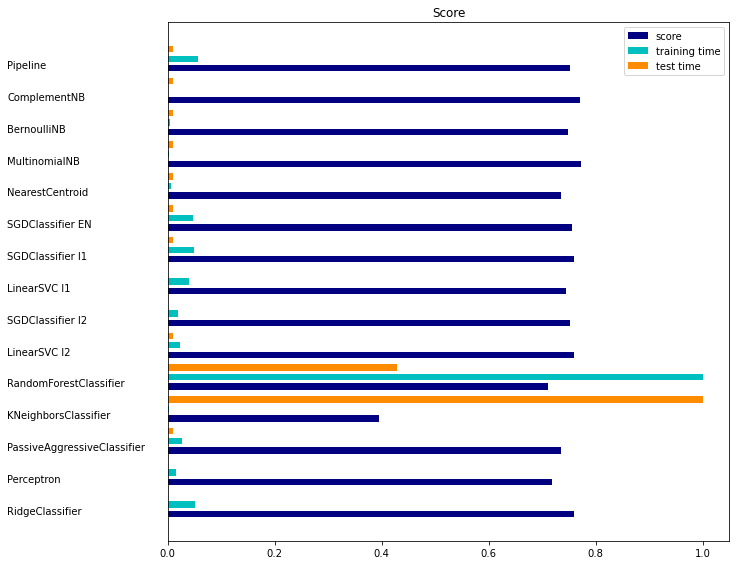

In [28]:
plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, 0.2, label="score", color="navy")
plt.barh(indices + 0.3, training_time, 0.2, label="training time", color="c")
plt.barh(indices + 0.6, test_time, 0.2, label="test time", color="darkorange")
plt.yticks(())
plt.legend(loc="best")
plt.subplots_adjust(left=0.25)
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(bottom=0.05)

for i, c in zip(indices, clf_names):
    plt.text(-0.3, i, c)

plt.show()

## one-off Kneighbors

In [29]:
y_train

array([1, 3, 2, ..., 1, 0, 1], dtype=int64)

In [30]:
pd.DataFrame(X_train.todense()).describe()

,0,1,2,3,4,5,6,7,8,9,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
count,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,...,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000
mean,0.001471,0.002999,0.000376,0.002156,0.000599,0.002771,0.000514,0.000599,0.001565,0.003045,...,0.000226,0.000275,0.001091,0.000942,0.000302,0.003947,0.005437,0.000844,0.000273,0.000964
std,0.014319,0.015627,0.008293,0.014780,0.010190,0.017775,0.011125,0.010190,0.015390,0.021971,...,0.010199,0.008000,0.016695,0.021118,0.012899,0.020612,0.021339,0.021277,0.005909,0.014158
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.280698,0.201979,0.259718,0.184582,0.214754,0.304715,0.342437,0.214754,0.354277,0.364062,...,0.459983,0.317610,0.475821,0.620357,0.580812,0.348775,0.224543,0.582961,0.164637,0.362648


In [31]:
#skeleton for one-off run
clf = KNeighborsClassifier(n_neighbors=10)

clf.fit(X_train, y_train)

pred = clf.predict(X_test)

score = metrics.accuracy_score(y_test, pred)


if hasattr(clf, "coef_"):
    print(f"dimensionality: {clf.coef_.shape[1]}" )
    print(f"density: {density(clf.coef_)}"  )

    if opts.print_top10 and feature_names is not None:
        print("top 10 keywords per class:")
        for i, label in enumerate(target_names):
            top10 = np.argsort(clf.coef_[i])[-10:]
            print(f"{label}: {' '.join(feature_names[top10])}".strip() )

if opts.print_report:
    print("classification report:")
    print(metrics.classification_report(y_test, pred, target_names=target_names))

if opts.print_cm:
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

result = ( "desc", score, "train_time", "test_time" )

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.32      0.42      0.36       319
     comp.graphics       0.49      0.48      0.48       389
         sci.space       0.47      0.45      0.46       394
talk.religion.misc       0.22      0.16      0.18       251

          accuracy                           0.39      1353
         macro avg       0.37      0.37      0.37      1353
      weighted avg       0.39      0.39      0.39      1353

confusion matrix:
[[133  47  81  58]
 [ 92 185  71  41]
 [101  78 177  38]
 [ 95  69  48  39]]


In [32]:
pred2 = clf.predict(X_train)
pred2 == y_train

array([False, False,  True, ..., False,  True, False])

In [34]:
clf.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 10,
 'p': 2,
 'weights': 'uniform'}

In [36]:
pd.Series(y_train).value_counts()

2    593
1    584
0    480
3    377
dtype: int64

In [38]:
pred_s = pd.Series(pred)
pred_s.value_counts()

0    421
1    379
2    377
3    176
dtype: int64

## one-off Kmeans clustering
clustering = un-labeled data = unsupervised

In [41]:
from sklearn.cluster import KMeans

In [42]:
clf = KMeans(n_clusters=4)

In [43]:
#skeleton for one-off run
clf.fit(X_train, y_train)

KMeans(n_clusters=4)

In [44]:
clf.cluster_centers_

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.07574390e-03, 2.82512826e-03, 2.13833867e-03, ...,
        0.00000000e+00, 0.00000000e+00, 4.97840507e-03],
       [1.57110575e-03, 3.14473586e-03, 0.00000000e+00, ...,
        1.20034446e-03, 0.00000000e+00, 9.95317325e-05],
       [0.00000000e+00, 2.52804116e-03, 0.00000000e+00, ...,
        0.00000000e+00, 2.38174330e-03, 1.53577359e-04]])

In [45]:
lab_s = pd.Series(clf.labels_)
lab_s.value_counts(0)

2    1431
1     358
3     233
0      12
dtype: int64

In [47]:
clf.labels_

array([1, 2, 2, ..., 1, 3, 2])

In [48]:
pd.DataFrame([('TP', 'FN'),('FP', 'TN')], columns = ['pred_pos', 'pred_neg'], index=['act_pos', 'act_neg'])

,pred_pos,pred_neg
act_pos,TP,FN
act_neg,FP,TN


## interpreting multi-class confusion matrix
[helps a bit but wording is confusing](https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/)

|population = P+N|pred_pos|pred_neg|
| --- | --- | --- |
|act_pos|TP|FN|
|act_neg|FP|TN|

- TP = 
    - prediction was correct - the diagonal of CF
    - CF\[0,0\]
- FN = 
    - predicted something other than actual 
    - for row 0 the sum of all values in columns\[1:\] for this row
    - The sum of valuesiun the row except the TP value

- FP = 
    - TBD 
    - for column 0 the sum of all values in rows\[1:\] 
    - The sum of values of corresponding column except the TP value.

- TN = 
    - we poredicted it wasn't this, and it isn't - 
    - The sum of everything that isn't in the row or column for the class

performance:
- Accuracy (ACC) = (TP + TN)/(P + N) = (true_pos+true_neg) / (act_pos+act_neg)
- precision= TP/PP = true_postive / sum(pred_pos)
- recall/sensitivity = TP/P  = true_positive / sum(act_pos)

### notes from a bad site with lots of tricksy pop-up ads
- accuracy
    - range 0 to 1
    - calc = (TP+TN) divided by 'total number of a dataset P+N' (what does that mean? everything)
    - balanced accruacy average of proprotion of corrects of each class individually 
    
### notes from a less bad site
https://medium.com/analytics-vidhya/confusion-matrix-accuracy-precision-recall-f1-score-ade299cf63cd
same author as the link above?
- accuracy = $ \large \frac{(TN+TP)}{(TN+TP+FP+FN)} $
- precision = $ \large \frac{TP}{(TP+FP)} $
- recall = $ \large\frac{TP}{(TP+FN)} $
-  F1 $ = 2 \times \large \frac{(precision \times recall)}{(precision + recall)} $ - is this being used in place of the accuracy score because accuracy == bad

### notes from BMC site
https://www.bmc.com/blogs/confusion-precision-recall/
- Precision = TP/(TP + FP)
- Recall = TP/(TP + FN)

In [112]:
CF = pd.DataFrame(metrics.confusion_matrix(y_train, clf.labels_))
#https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/

TP = CF.loc[0,0] # TP are on the diag
FN = CF.loc[0, 1:] #all columns not on the dia
#report to reproduce
print(metrics.classification_report(y_train, clf.labels_, target_names=target_names))
metrics.accuracy_score(y_train, clf.labels_)

                    precision    recall  f1-score   support

       alt.atheism       0.50      0.01      0.02       480
     comp.graphics       0.94      0.58      0.72       584
         sci.space       0.40      0.97      0.57       593
talk.religion.misc       0.46      0.28      0.35       377

          accuracy                           0.50      2034
         macro avg       0.58      0.46      0.41      2034
      weighted avg       0.59      0.50      0.44      2034



0.5039331366764995

In [111]:
print('the row(predictions)', CF.loc[0].to_frame().T, sep='\n')#the row (predictions)

print('the col(actuals)',CF.loc[:, 0].to_frame(), sep='\n') #the column (actuals)
CF

the row(predictions)
   0  1    2    3
0  6  1  347  126
the col(actuals)
   0
0  6
1  0
2  0
3  6


,0,1,2,3
0,6,1,347,126
1,0,337,247,0
2,0,18,575,0
3,6,2,262,107


In [114]:
#does the metrics module computes TP, FP, FN, TN for all classes and take the average
#accuracy is reported as f1 so I do not think it is using the commonly reported calc
def get_confusion(CF, i):
    """
    demonstration of taking apart the multi-variate confusion matrix to get teh 2x2
    and also calculate the common metrics for each classification group
    CF: a multivariate confusiotn matrix (DataFrame from ndarray)
    i: the variable index for which to show the traditional 2x2 confusion matrix
    
    computed accuracy score matches with the 'macro avg' computed by sklearn.metrics.classification_report
    """
    TP = CF.loc[i,i]
    FN = CF.loc[i].sum() - TP
    FP = CF.loc[:, i].sum() - TP
    TN = CF.values.sum() - CF.loc[i].sum() - CF.loc[:,i].sum() + TP # or CF.values.sum() - FN - FP
    #since TP is subtracted twice (as part of the row and as part of the column - need to add it back once to get the right total)
    cfout =pd.DataFrame([[TP,FN],[FP,TN]], columns = ['pred_pos', 'pred_neg'], index=['act_pos', 'act_neg'])
    #act_neg = FP + TN
    accuracy = (TP+TN)/(TP+TN+FP+FN) # (TP+TN)/(TP+FN)
    precision = TP / (TP+FP) #yes, but no? #TP/pred_pos #pred_pos = TP + FP # 
    recall =  TP/(TP+FN) #TP/act_pos #act_pos = TP + FN#
    f1 = 2*(precision * recall) / (precision+recall)
    #print((i), f"TP is {TP}; FP is {FP}; FN is {FN}; TN is {TN}" )
    cols = ['TP', 'FP', 'FN', 'TN', 'accuracy', 'precision', 'recall', 'f1']
    res = pd.Series([TP, FP, FN, TN, accuracy, precision, recall, f1 ], index=cols)
    return res

#for i in CF.index:
#    get_confusion(CF, i)

#get_confusion(CF, 0)

allgroups = pd.Series(CF.index).apply(lambda x: get_confusion(CF, x))
print(allgroups.mean())
allgroups.index = target_names #replace numeric index with category names
allgroups

TP            256.250000
FP            252.250000
FN            252.250000
TN           1273.250000
accuracy        0.751967
precision       0.575596
recall          0.460755
f1              0.414723
dtype: float64


,TP,FP,FN,TN,accuracy,precision,recall,f1
alt.atheism,6.0,6.0,474.0,1548.0,0.764012,0.500000,0.012500,0.024390
comp.graphics,337.0,21.0,247.0,1429.0,0.868240,0.941341,0.577055,0.715499
sci.space,575.0,856.0,18.0,585.0,0.570305,0.401817,0.969646,0.568182
talk.religion.misc,107.0,126.0,270.0,1531.0,0.805310,0.459227,0.283820,0.350820


## accuracy score vs actual real labels
from documentation: 

> The reported averages include macro average (averaging the unweighted
mean per label), weighted average (averaging the support-weighted mean
per label), and sample average (only for multilabel classification).
Micro average (averaging the total true positives, false negatives and
false positives) is only shown for multi-label or multi-class
with a subset of classes, because it corresponds to accuracy otherwise.
See also `precision_recall_fscore_support` for more details
on averages.
>
>Note that in binary classification, recall of the positive class
is also known as "sensitivity"; recall of the negative class is
"specificity".


In [83]:
metrics.classification_report(y_test, pred, target_names=target_names, output_dict=True)

{'alt.atheism': {'precision': 0.3159144893111639,
  'recall': 0.4169278996865204,
  'f1-score': 0.35945945945945945,
  'support': 319},
 'comp.graphics': {'precision': 0.48812664907651715,
  'recall': 0.4755784061696658,
  'f1-score': 0.48177083333333326,
  'support': 389},
 'sci.space': {'precision': 0.46949602122015915,
  'recall': 0.44923857868020306,
  'f1-score': 0.4591439688715953,
  'support': 394},
 'talk.religion.misc': {'precision': 0.2215909090909091,
  'recall': 0.1553784860557769,
  'f1-score': 0.18266978922716626,
  'support': 251},
 'accuracy': 0.3946784922394678,
 'macro avg': {'precision': 0.37378201717468734,
  'recall': 0.37428084264804157,
  'f1-score': 0.3707610127228886,
  'support': 1353},
 'weighted avg': {'precision': 0.39265243098565217,
  'recall': 0.3946784922394678,
  'f1-score': 0.3908568089916197,
  'support': 1353}}

In [88]:
score = metrics.accuracy_score(y_train, clf.labels_)
print(f"acc score is {score}")

if hasattr(clf, "coef_"):
    print(f"dimensionality: {clf.coef_.shape[1]}" )
    print(f"density: {density(clf.coef_)}"  )

    if opts.print_top10 and feature_names is not None:
        print("top 10 keywords per class:")
        for i, label in enumerate(target_names):
            top10 = np.argsort(clf.coef_[i])[-10:]
            print(f"{label}: {' '.join(feature_names[top10])}".strip() )

if opts.print_report:
    print("classification report:")
    print(metrics.classification_report(y_test, pred, target_names=target_names))

if opts.print_cm:
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

result = ( "desc", score, "train_time", "test_time" )

acc score is 0.5039331366764995
classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.32      0.42      0.36       319
     comp.graphics       0.49      0.48      0.48       389
         sci.space       0.47      0.45      0.46       394
talk.religion.misc       0.22      0.16      0.18       251

          accuracy                           0.39      1353
         macro avg       0.37      0.37      0.37      1353
      weighted avg       0.39      0.39      0.39      1353

confusion matrix:
[[133  47  81  58]
 [ 92 185  71  41]
 [101  78 177  38]
 [ 95  69  48  39]]


In [89]:
pred = clf.predict(X_test)

In [90]:
score = metrics.accuracy_score(y_test, pred)


if hasattr(clf, "coef_"):
    print(f"dimensionality: {clf.coef_.shape[1]}" )
    print(f"density: {density(clf.coef_)}"  )

    if opts.print_top10 and feature_names is not None:
        print("top 10 keywords per class:")
        for i, label in enumerate(target_names):
            top10 = np.argsort(clf.coef_[i])[-10:]
            print(f"{label}: {' '.join(feature_names[top10])}".strip() )

if opts.print_report:
    print("classification report:")
    print(metrics.classification_report(y_test, pred, target_names=target_names))

if opts.print_cm:
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

result = ( "desc", score, "train_time", "test_time" )

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.01      0.01      0.01       319
     comp.graphics       0.00      0.00      0.00       389
         sci.space       0.36      0.97      0.52       394
talk.religion.misc       0.00      0.00      0.00       251

          accuracy                           0.28      1353
         macro avg       0.09      0.24      0.13      1353
      weighted avg       0.11      0.28      0.15      1353

confusion matrix:
[[  2   0 310   7]
 [261   0 128   0]
 [ 12   0 382   0]
 [  3   0 248   0]]


C:\Users\Rob.DESKTOP-HBG5EOT\.conda\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
